In [326]:
import numpy as np

In [327]:
class XavierInitializer:
    """
    Xavier Initializer
    Parameters
    ----------
    n_nodes1 : number of nodes in the first layer / number of channels
    """
    def __init__(self, n_nodes1):
        self.sigma = 1.0 / n_nodes1**(1/2)

    def W(self, n_nodes1, n_nodes2):
        """
        Weight initialization
        Parameters
        ----------
        n_nodes1 : int
          Number of nodes in the previous layer / number of channels
        n_nodes2 : int
          Number of nodes in the later layer / number of features
        Returns
        ----------
        W : weight
        """
        return self.sigma * np.random.randn(n_nodes1, n_nodes2)

    def B(self, n_nodes2):
        """
        Bias initialization
        Parameters
        ----------
        n_nodes2 : int
          Number of nodes in the later layer / number of features
        Returns
        ----------
        B : bias
        """
        return self.sigma * np.random.randn(n_nodes2)

In [328]:
class SimpleInitializer:
    """
    Simple initialization with Gaussian distribution
    Parameters
    ----------
    sigma : float
      Standard deviation of Gaussian distribution
    """
    def __init__(self, sigma=0.01):
        self.sigma = sigma

    def W(self, n_nodes1, n_nodes2):
        """
        Weight initialization
        Parameters
        ----------
        n_nodes1 : int
          Number of nodes in the previous layer
        n_nodes2 : int
          Number of nodes in the later layer
        Returns
        ----------
        W : weight
        """
        return self.sigma * np.random.randn(n_nodes1, n_nodes2)

    def B(self, n_nodes2):
        """
        Bias initialization
        Parameters
        ----------
        n_nodes2 : int
          Number of nodes in the later layer
        Returns
        ----------
        B : bias
        """
        return self.sigma * np.random.randn(n_nodes2)

In [329]:
class HeInitializer:
    def __init__(self, n_nodes1):
        self.sigma = (2.0 / n_nodes1)**(1/2)

    def W(self, n_nodes1, n_nodes2):
        return self.sigma * np.random.randn(n_nodes1, n_nodes2)

    def B(self, n_nodes2):
        return self.sigma * np.random.randn(n_nodes2)

In [330]:
class ReLU:
    def forward(self, A):
        return np.maximum(A, 0)
    
    def backward(self, dZ, Z):
        return dZ * (Z > 0)

In [331]:
class Softmax:
    def forward(self, A):
        return np.exp(A) / np.sum(np.exp(A), axis=1).reshape(-1, 1)
    
    def backward(self, Z, y):
        """return dA, CEE"""
        return (Z - y) / y.shape[0], -np.sum((y * np.log(Z + 1e-7))) / y.shape[0]

In [332]:
class SGD:
    """
    Stochastic gradient descent
    Parameters
    ----------
    lr : Learning rate
    """
    def __init__(self, lr=0.01):
        self.lr = lr

    def update(self, layer):
        """
        Update weights and biases for a layer
        Parameters
        ----------
        layer : Instance of the layer before update
        """
        layer.W -= self.lr * layer.dW
        layer.B -= self.lr * layer.dB
        return layer

<h2>[Problem 1] Creating a one-dimensional convolutional layer class that limits the number of channels to one</h2>

In [333]:
class SimpleConv1d:
    def __init__(self, F, initializer, optimizer):
        self.F = F
        self.optimizer = optimizer
        self.W = np.squeeze(initializer.W(1, F))
        self.B = np.squeeze(initializer.B(1))

    def forward(self, X):
        """
        forward propagation, finding A
        Parameters
        ----------
        X : (features, )
        Return
        ----------
        A : (n_out, )
        """
        self.X = X
        self.n_out = compute_output_size(len(X), 0, self.F, 1)
        A = np.empty(self.n_out)
        for i in np.arange(0, self.n_out):
            A[i] = np.dot(X[i:i+self.F], self.W) + self.B
        return A

    def backward(self, dA):
        #update dW
        self.dW = np.empty(self.F)
        for s in np.arange(0, self.F):
            self.dW[s] = np.dot(dA, self.X[s:s+len(dA)])
        #update dB
        self.dB = np.sum(dA)
        #update dZ
        self.dZ = np.empty(len(self.X))
        for j in np.arange(0, len(self.X)):
            total = 0.0
            for s in np.arange(0, self.F):
                if (j - s >= 0 and j - s < len(dA)):
                    total += dA[j - s] * self.W[s]
            self.dZ[j] = total
        # update new W, B
        self = self.optimizer.update(self)
        return self.dZ

<h2>[Problem 2] Output size calculation after one-dimensional convolution</h2>

In [334]:
def compute_output_size(n_in, P, F, S):
    return int(1 + (n_in + 2*P - F) / S)

<h2>[Problem 3] Experiment of one-dimensional convolutional layer with small array</h2>

<h3>Forward</h3>

In [335]:
x = np.array([1,2,3,4]).astype(np.float64)
w = np.array([3, 5, 7]).astype(np.float64)
b = np.array([1]).astype(np.float64)

In [336]:
simplec1d = SimpleConv1d(len(w), XavierInitializer(len(x)), SGD())
simplec1d.B = b
simplec1d.W = w

In [337]:
A = simplec1d.forward(x)
print("A: {}".format(A))

A: [35. 50.]


<h3>Backward</h3>

In [338]:
dA = np.array([10, 20]).astype(np.float64)
simplec1d.backward(dA)
print("dW: {}\ndB: {}\ndZ: {}".format(simplec1d.dW, simplec1d.dB, simplec1d.dZ))

dW: [ 50.  80. 110.]
dB: 30.0
dZ: [ 30. 110. 170. 140.]


<h2>[Problem 4] Creating a one-dimensional convolutional layer class that does not limit the number of channels</h2>

In [339]:
class Conv1d:
    """
    A class of a convolution 1D layer
    Parameters
    ----------
    F : int
      filter size
    ch_in : int
      input channels
    ch_in : int
      output channels
    initializer: instance of initialization method
    optimizer: instance of optimization method
    """
    def __init__(self, F, ch_in, ch_out, initializer, optimizer):
        self.F = F
        self.ch_in = ch_in
        self.ch_out = ch_out
        self.optimizer = optimizer
        self.W = np.empty((ch_out, ch_in, F))
        for ch in np.arange(0, ch_out):
            self.W[ch] = initializer.W(ch_in, F)
        self.B = initializer.B(ch_out)

    def forward(self, X):
        """
        forward propagation, finding A
        Parameters
        ----------
        X : (ch_in, number of features)
        Return
        ----------
        A : (number of output channels, n_out)
        """
        self.X = X
        self.n_out = compute_output_size(self.X.shape[1], 0, self.F, 1)
        A = np.empty((self.ch_out, self.n_out))
        for ch in np.arange(0, self.ch_out):
            for i in np.arange(0, self.n_out):
                A[ch, i] = np.sum(X[:, i:i+self.F] * self.W[ch]) + self.B[ch]
        return A

    def backward(self, dA):
        """
        Backward
        Parameters
        ----------
        dA : The following forms of ndarray, shape (ch_out, n_out)
            Gradient flowing from behind
        Returns
        ----------
        dZ : The following forms of ndarray, shape (ch_in, number of features)
            Gradient to flow forward
        """
        #update dW
        self.dW = np.empty((self.ch_out, self.ch_in, self.F))
        for c_out in np.arange(0, self.ch_out):
            for c_in in np.arange(0, self.ch_in):
                for s in np.arange(0, self.F):
                    self.dW[c_out, c_in, s] = np.sum(dA[c_out] * self.X[c_in, s:s+self.n_out])
        #update dB
        self.dB = np.sum(dA, axis=1)
        #update dZ
        self.dZ = np.empty((self.ch_in, self.X.shape[1]))
        for c_in in np.arange(0, self.ch_in):
            for j in np.arange(0, self.X.shape[1]):
                total = 0.0
                for c_out in np.arange(0, self.ch_out):
                    for s in np.arange(0, self.F):
                        if (j - s >= 0 and j - s < self.n_out):
                            total += dA[c_out, j - s] * self.W[c_out, c_in, s]
                self.dZ[c_in, j] = total
        # update new W, B
        self = self.optimizer.update(self)
        return self.dZ

<h3>Testcase 1</h3>

<h4>Forward</h4>

In [340]:
x = np.array([[1, 2, 3, 4], [2, 3, 4, 5]]).astype(np.float64) #shape (2, 4), (number of input channels, number of features).
w = np.ones((3, 2, 3)).astype(np.float64) # Set to 1 for simplification of the example. (Number of output channels, number of input channels, filter size).
b = np.array([1, 2, 3]).astype(np.float64) # (Number of output channels)

In [341]:
con1d = Conv1d(w.shape[2], w.shape[1], w.shape[0], XavierInitializer(x.shape[0]), SGD())
con1d.W = w
con1d.B = b

In [342]:
A = con1d.forward(x)
print("A: \n{}".format(A))

A: 
[[16. 22.]
 [17. 23.]
 [18. 24.]]


<h4>Backward</h4>

In [343]:
dA = np.array([[10, 11], [20, 30], [35, 21]]).astype(np.float64)
con1d.backward(dA)
print("dW: \n{}\ndB: \n{}\ndZ: \n{}".format(con1d.dW, con1d.dB, con1d.dZ))

dW: 
[[[ 32.  53.  74.]
  [ 53.  74.  95.]]

 [[ 80. 130. 180.]
  [130. 180. 230.]]

 [[ 77. 133. 189.]
  [133. 189. 245.]]]
dB: 
[21. 50. 56.]
dZ: 
[[ 65. 127. 127.  62.]
 [ 65. 127. 127.  62.]]


<h3>Testcase 2</h3>

<h4>Forward</h4>

In [344]:
x = np.array([[1,2,3,4]]).astype(np.float64)
w = np.array([[[3, 5, 7]]]).astype(np.float64)
b = np.array([1]).astype(np.float64)

In [345]:
con1d = Conv1d(w.shape[2], w.shape[1], w.shape[0], XavierInitializer(x.shape[0]), SGD())
con1d.W = w
con1d.B = b

In [346]:
A = con1d.forward(x)
print("A: {}".format(A))

A: [[35. 50.]]


<h4>Backward</h4>

In [347]:
dA = np.array([[10, 20]]).astype(np.float64)
con1d.backward(dA)
print("dW: {}\ndB: {}\ndZ: {}".format(con1d.dW, con1d.dB, con1d.dZ))

dW: [[[ 50.  80. 110.]]]
dB: [30.]
dZ: [[ 30. 110. 170. 140.]]


<h2>[Problem 8] Learning and estimation</h2>

In [348]:
class GetMiniBatch:
    """
    Iterator to get a mini-batch
    Parameters
    ----------
    X : The following forms of ndarray, shape (n_samples, n_features)
      Training data
    y : The following form of ndarray, shape (n_samples, 1)
      Correct answer value
    batch_size : int
      Batch size
    seed : int
      NumPy random number seed
    """
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)

    def __len__(self):
        return self._stop

    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]   

    def __iter__(self):
        self._counter = 0
        return self

    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

In [349]:
class FC:
    """
    Number of nodes Fully connected layer from n_nodes1 to n_nodes2
    Parameters
    ----------
    n_nodes1 : int
      Number of nodes in the previous layer
    n_nodes2 : int
      Number of nodes in the later layer
    initializer: instance of initialization method
    optimizer: instance of optimization method
    """
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
        self.optimizer = optimizer
        # Initialize
        # Initialize self.W and self.B using the initializer method
        self.W = initializer.W(n_nodes1, n_nodes2)
        self.B = initializer.B(n_nodes2)

    def forward(self, X):
        """
        forward
        Parameters
        ----------
        X : The following forms of ndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        A : The following forms of ndarray, shape (batch_size, n_nodes2)
            output
        """       
        self.X = X
        A = X @ self.W + self.B
        return A

    def backward(self, dA):
        """
        Backward
        Parameters
        ----------
        dA : The following forms of ndarray, shape (batch_size, n_nodes2)
            Gradient flowing from behind
        Returns
        ----------
        dZ : The following forms of ndarray, shape (batch_size, n_nodes1)
            Gradient to flow forward
        """
        self.dA = dA
        dZ = dA @ self.W.T
        self.dW = self.X.T @ dA
        self.dB = np.sum(dA, axis=0)
        # update
        self = self.optimizer.update(self)
        return dZ

In [350]:
class Scratch1dCNNClassifier:
    def __init__(self,
                conv_filter_size=[3],
                hidden_layers=[400,200],
                hidden_activations=['tanh', 'tanh'],
                hidden_initializers=['gaussian', 'gaussian'],
                sigma=0.01,
                optimizer='sgd',
                layer_type=None,
                batch_size=20,
                epochs=10,
                lr=0.01,
                seed=0,
                verbose=False
                ):
        self.F = conv_filter_size
        self.hidden_layers = hidden_layers
        self.activations_name = hidden_activations.copy()
        self.activations_name.insert(0, None)
        self.activations_name.append('softmax')
        self.initializers = hidden_initializers.copy()
        self.initializers.insert(0, None)
        self.initializers.append('gaussian')
        self.sigma = sigma
        self.optimizer = optimizer
        self.layer_type = layer_type
        self.batch_size = batch_size
        self.epochs = epochs
        self.lr = lr
        self.seed = seed
        self.verbose = verbose

    def _initialize_neural_network(self):
        #initialize conv layers
        self.conv = np.full(len(self.F) + 1, None)
        self.conv_activations = np.full(len(self.F) + 1, None)
        for i in np.arange(1, len(self.F) + 1):
            self.conv[i] = Conv1d(self.F[i - 1], 1, 1, HeInitializer(1), SGD(self.lr))
            self.conv_activations[i] = ReLU()
        #choose activations
        self.activations = np.full(len(self.n_nodes), None) #activations[0] unused
        for i in np.arange(1, len(self.n_nodes)):
            if (self.activations_name[i] == 'tanh'):
                self.activations[i] = Tanh()
            elif (self.activations_name[i] == 'sigmoid'):
                self.activations[i] = Sigmoid()
            elif (self.activations_name[i] == 'relu'):
                self.activations[i] = ReLU()
            elif (self.activations_name[i] == 'softmax'):
                self.activations[i] = Softmax()
        #choose initializer, optimizer and build neural network
        self.FC = np.full(len(self.n_nodes), None) #FC[0] unused
        for i in np.arange(1, len(self.n_nodes)):
            if (self.optimizer == 'sgd'):
                if (self.initializers[i] == 'gaussian'):
                    self.FC[i] = FC(self.n_nodes[i - 1], self.n_nodes[i], SimpleInitializer(self.sigma), SGD(self.lr))
                elif (self.initializers[i] == 'xavier'):
                    self.FC[i] = FC(self.n_nodes[i - 1], self.n_nodes[i], XavierInitializer(self.n_nodes[i - 1]), SGD(self.lr))
                elif (self.initializers[i] == 'he'):   
                    self.FC[i] = FC(self.n_nodes[i - 1], self.n_nodes[i], HeInitializer(self.n_nodes[i - 1]), SGD(self.lr))
            elif (self.optimizer == 'adagrad'):
                if (self.initializers[i] == 'gaussian'):
                    self.FC[i] = FC(self.n_nodes[i - 1], self.n_nodes[i], SimpleInitializer(self.sigma), AdaGrad(self.lr, (self.n_nodes[i - 1], self.n_nodes[i])))
                elif (self.initializers[i] == 'xavier'):
                    self.FC[i] = FC(self.n_nodes[i - 1], self.n_nodes[i], XavierInitializer(self.n_nodes[i - 1]), AdaGrad(self.lr, (self.n_nodes[i - 1], self.n_nodes[i])))
                elif (self.initializers[i] == 'he'):   
                    self.FC[i] = FC(self.n_nodes[i - 1], self.n_nodes[i], HeInitializer(self.n_nodes[i - 1]), AdaGrad(self.lr, (self.n_nodes[i - 1], self.n_nodes[i])))

    def _forward(self, X):
        #conv
        A_conv = np.full(len(self.F) + 1, None)
        Z_conv = np.full(len(self.F) + 1, None)
        Z_conv[0] = X
        for i in np.arange(1, len(self.F) + 1):
            A_conv[i] = self.conv[i].forward(Z_conv[i - 1])
            Z_conv[i] = self.conv_activations[i].forward(A_conv[i])
        #FC
        A = np.full(len(self.n_nodes), None) #A[0] unused
        Z = np.full(len(self.n_nodes), None)
        Z[0] = Z_conv[-1]
        for i in np.arange(1, len(self.n_nodes)):
            A[i] = self.FC[i].forward(Z[i - 1])
            Z[i] = self.activations[i].forward(A[i])
        return Z, Z_conv

    def _backward(self, y, Z, Z_conv):
        #FC
        dA = np.full(len(self.n_nodes), None) #A[0] unused
        dZ = np.full(len(self.n_nodes), None) #Z[-1] unused
        CEE = None
        for i in np.arange(len(self.n_nodes) - 1, 0, -1):
            if (self.activations_name[i] == 'softmax'):
                dA[i], CEE = self.activations[i].backward(Z[i], y)
            else:
                dA[i] = self.activations[i].backward(dZ[i], Z[i])
            dZ[i - 1] = self.FC[i].backward(dA[i])
        #conv
        dA_conv = np.full(len(self.F) + 1, None)
        dZ_conv = np.full(len(self.F) + 1, None)
        dZ_conv[-1] = dZ[0]
        for i in np.arange(len(self.F), 0, -1):
            dA_conv[i] = self.conv_activations[i].backward(dZ_conv[i], Z_conv[i])
            dZ_conv[i - 1] = self.conv[i].backward(dA_conv[i])
        return CEE

    def _compute_CEE(self, y, Z):
        return -np.sum((y * np.log(Z + 1e-7))) / y.shape[0]

    def _optimize(self, X, y, X_val=None, y_val=None):
        self.CEE_list = []
        self.CEE_list_val = []
        get_mini_batch = GetMiniBatch(X, y, batch_size=self.batch_size, seed=self.seed)
        for _ in np.arange(0, self.epochs):
            for mini_X, mini_y in get_mini_batch:
                Z, Z_conv = self._forward(mini_X)
                CEE = self._backward(mini_y, Z, Z_conv)
                self.CEE_list.append(CEE)
            if (X_val is not None and y_val is not None):
                Z, _ = self._forward(X_val)
                self.CEE_list_val.append(self._compute_CEE(y_val, Z[-1]))

    def fit(self, X, y, X_val=None, y_val=None):
        """
        Learn a neural network classifier.
        Parameters
        ----------
        X : The following forms of ndarray, shape (n_samples, n_features)
            Features of training data
        y : The following form of ndarray, shape (n_samples,)
            Correct answer value of training data
        X_val : The following forms of ndarray, shape (n_samples, n_features)
            Features of verification data
        y_val : The following form of ndarray, shape (n_samples,)
            Correct value of verification data
        """
        self.n_output = y.shape[1]
        self.n_features = X.shape[1]
        self.n_nodes = self.hidden_layers.copy()
        n_out = len(X[0])
        for i in np.arange(0, len(self.F)):
            n_out = compute_output_size(n_out, 0, self.F[i], 1)
        self.n_nodes.insert(0, n_out)
        self.n_nodes.append(self.n_output)
        self._initialize_neural_network()
        self._optimize(X, y, X_val, y_val)

    def predict(self, X):
        """
        Estimate using a neural network classifier.
        Parameters
        ----------
        X : The following forms of ndarray, shape (n_samples, n_features)
            sample
        Returns
        -------
            The following form of ndarray, shape (n_samples, 1)
            Estimated result
        """
        Z_ret = []
        for x in X:
            Z_pred, _ = self._forward(np.array([x]))
            Z_ret.append(np.argmax(Z_pred[-1]))
        return np.array(Z_ret)

<h3>Learning</h3>

In [351]:
import matplotlib.pyplot as plt
from keras.datasets import mnist
from sklearn.metrics import accuracy_score

In [352]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(-1, 784)[:6000]
X_test = X_test.reshape(-1, 784)[:6000]

y_train = y_train[:6000]
y_test = y_test[:6000]

X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255

In [353]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])

In [354]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train_one_hot, test_size=0.2)

In [355]:
def plot_CEE(CEE_list=None, CEE_list_val=None, epochs=None):
    """plot final CEE for every epochs"""
    if (CEE_list is not None):
        plt.plot(np.arange(1, epochs + 1), CEE_list[::int(len(CEE_list)/epochs)], label="train", marker='o')
    if (CEE_list_val is not None):
        plt.plot(np.arange(1, epochs + 1), CEE_list_val, label="val", marker='o')
    plt.legend()
    plt.xlabel("iter")
    plt.ylabel("CEE")
    plt.title("CEE graph")
    plt.grid()
    plt.show()

In [356]:
def draw_fault(y_pred, y_val):
    """
    Display word classification results side by side. The display above the image is "estimated result / correct answer".
    Parameters:
    ----------
    y_pred : Estimated ndarray (n_samples,)
    y_val : Correct label of verification data (n_samples,)
    X_val : Verification data features (n_samples, n_features)
    """
    num = 36 # How many to display

    true_false = y_pred==y_val
    false_list = np.where(true_false==False)[0].astype(np.int)
    if false_list.shape[0] < num:
        num = false_list.shape[0]
    fig = plt.figure(figsize=(6, 6))
    fig.subplots_adjust(left=0, right=0.8,  bottom=0, top=0.8, hspace=1, wspace=0.5)
    for i in range(num):
        ax = fig.add_subplot(6, 6, i + 1, xticks=[], yticks=[])
        ax.set_title("{} / {}".format(y_pred[false_list[i]],y_val[false_list[i]]))
        ax.imshow(X_val.reshape(-1,28,28)[false_list[i]], cmap='gray')

In [357]:
def save_model(model_name, model):
    np.savez(model_name + '.npz', model)

In [358]:
def handler(model=None, X_train=None, y_train=None, X_val=None, y_val=None, epochs=None, save=False, file_name=None):
    model.fit(X_train, y_train, X_val, y_val)
    y_pred = model.predict(X_val)
    unique_elements, counts_elements = np.unique(y_pred - np.argmax(y_val, axis=1), return_counts=True)
    print("number of correct cases: {}/{}".format(int(counts_elements[unique_elements == 0]), y_pred.shape[0]))
    print("Accuracy: {}".format(accuracy_score(np.argmax(y_val, axis=1), y_pred)))
    plot_CEE(CEE_list=model.CEE_list, CEE_list_val=model.CEE_list_val, epochs=epochs)
    draw_fault(y_pred, np.argmax(y_val, axis=1))
    if (save == True):
        save_model('file_name', model)

<h4>Case 1 - add 2 convolution layers</h4>

In [359]:
epochs = 1
batch_size = 1

number of correct cases: 142/1200
Accuracy: 0.11833333333333333


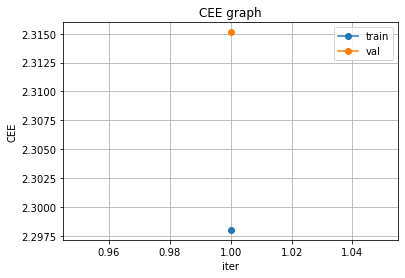

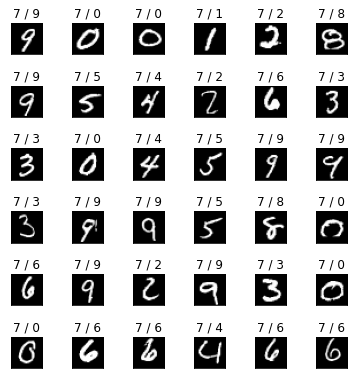

In [360]:
cnn_1 = Scratch1dCNNClassifier(
                conv_filter_size=[20, 10],
                hidden_layers=[400,200],
                hidden_activations=['relu', 'relu'],
                hidden_initializers=['he', 'he'],
                sigma=0.01,
                optimizer='sgd',
                layer_type=None,
                batch_size=batch_size,
                epochs=epochs,
                lr=0.05,
                seed=69,
                verbose=False       
)

handler(cnn_1, X_train, y_train, X_val, y_val, epochs)